# Modeling

In this notebook we use the cleaned dataset to generate and evaluate models. 

In [1]:
## necessary imports

# standard data science libraries
import numpy as np
import pandas as pd
from patsy import dmatrices, dmatrix
import re
import pickle
from rfpimp import *
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # make prettier plots


# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from collections import Counter


# modeling
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification

# model evaluation
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score


# set random seed for reproducability
seed = 5
np.random.seed(seed)


# set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Load in the cleaned dataset

In [2]:
with open('cleaned_cc_default_data', 'rb') as file:
    model_data = pickle.load(file)

In [3]:
model_data.head()

,default_payment_next_month,age,education_level,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,limit_balance,sex,others,single
0,0,39,3.0,47174,47974,48630,50803,30789,15874,0,0,0,0,0,0,1800,2000,3000,2000,2000,2000,50000,1,0,1
1,0,29,3.0,48088,45980,44231,32489,26354,20221,0,0,0,0,0,0,2000,2010,3000,3000,3000,1000,110000,0,0,1
2,0,36,3.0,78630,68921,46512,40335,37165,22156,0,0,0,2,0,0,10076,4018,14,2051,2000,0,270000,1,0,1
3,0,45,3.0,58180,59134,61156,62377,63832,65099,0,0,0,0,0,0,2886,2908,2129,2354,2366,2291,130000,1,0,0
4,0,24,3.0,42058,35340,22110,19837,19855,20151,0,0,0,0,0,0,1367,1606,692,709,721,692,50000,1,0,1


In [4]:
model_data.shape

(2963, 25)

### Scale the data and train-test split

We first do a stratified train-test split on the dataset. 

In [5]:
# Stratified train-test split
x_raw = model_data.iloc[:, 1:]
y_raw = np.array(model_data['default_payment_next_month'])

sss1 = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)

sss1.get_n_splits()
for train_index, test_index in sss1.split(x_raw, y_raw):
    x_train, x_test = x_raw.loc[train_index,:], x_raw.loc[test_index,:]
    y_train, y_test = y_raw[train_index], y_raw[test_index]

/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [6]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (2370, 24)
y_train shape: (2370,)
x_test shape: (593, 24)
y_test shape: (593,)


Next we scale the data using a standard scaler. 

In [7]:
# setting a scaler

scaler = StandardScaler()

In [8]:
# splitting train data into features that will be scaled
# by dropping categorical features

X_for_scaling = x_train.drop(columns=['education_level', 
        'pay_0', 'pay_2', 'pay_3','pay_4', 'pay_5', 'pay_6', 
        'sex', 'others', 'single'])

In [9]:
# scale features that need to be scaled

X_train_scaled = scaler.fit_transform(X_for_scaling)

In [10]:
# convert those features to data frame

X_train_scaled = pd.DataFrame(X_train_scaled, columns=['age', 
       'bill_amt_1', 'bill_amt_2', 'bill_amt_3','bill_amt_4', 'bill_amt_5', 'bill_amt_6', 
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3','pay_amt_4', 'pay_amt_5', 'pay_amt_6', 
       'limit_balance'])

In [11]:
# merge scaled features with non-scaled features to recreate the full dataset

X_train = X_train_scaled.join(x_train.drop(columns=['age', 
       'bill_amt_1', 'bill_amt_2', 'bill_amt_3','bill_amt_4', 'bill_amt_5', 'bill_amt_6', 
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3','pay_amt_4', 'pay_amt_5', 'pay_amt_6', 
       'limit_balance']).reset_index(drop=True))

In [19]:
# get null value indices in X_train

inds = pd.isnull(X_train).any(1).nonzero()[0]
inds

/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  This is separate from the ipykernel package so we can avoid doing imports until


array([1391, 1867])

In [20]:
# drop the above indices with null values from X_train and y_train

X_train.drop([1391, 1867], inplace = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2368 entries, 0 to 2369
Data columns (total 24 columns):
age                2368 non-null float64
bill_amt_1         2368 non-null float64
bill_amt_2         2368 non-null float64
bill_amt_3         2368 non-null float64
bill_amt_4         2368 non-null float64
bill_amt_5         2368 non-null float64
bill_amt_6         2368 non-null float64
pay_amt_1          2368 non-null float64
pay_amt_2          2368 non-null float64
pay_amt_3          2368 non-null float64
pay_amt_4          2368 non-null float64
pay_amt_5          2368 non-null float64
pay_amt_6          2368 non-null float64
limit_balance      2368 non-null float64
education_level    2368 non-null float64
pay_0              2368 non-null float64
pay_2              2368 non-null float64
pay_3              2368 non-null float64
pay_4              2368 non-null float64
pay_5              2368 non-null float64
pay_6              2368 non-null float64
sex                2368 non-null

In [21]:
# converted y_train into a dataframe so I can deal with null values in x_train

y_train = pd.DataFrame(y_train, columns=['credit_card_default'])

In [22]:
# drop same rows with null values from y_train

y_train.drop([1391, 1867], inplace = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2368 entries, 0 to 2369
Data columns (total 1 columns):
credit_card_default    2368 non-null int64
dtypes: int64(1)
memory usage: 37.0 KB


In [23]:
# split test data into features that will be scaled by dropping categorical features (same process as train data)

X_for_scaling2 = x_test.drop(columns=['education_level', 
        'pay_0', 'pay_2', 'pay_3','pay_4', 'pay_5', 'pay_6', 
        'sex', 'others', 'single'])

In [24]:
# scale test features

X_test_scaled = scaler.fit_transform(X_for_scaling2)

In [25]:
# convert those features to dataframe

X_test_scaled = pd.DataFrame(X_test_scaled, columns=['age', 
       'bill_amt_1', 'bill_amt_2', 'bill_amt_3','bill_amt_4', 'bill_amt_5', 'bill_amt_6', 
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3','pay_amt_4', 'pay_amt_5', 'pay_amt_6', 
       'limit_balance'])

In [26]:
# merge with categorical features that weren't scaled

X_test = X_test_scaled.join(x_test.drop(columns=['age', 
       'bill_amt_1', 'bill_amt_2', 'bill_amt_3','bill_amt_4', 'bill_amt_5', 'bill_amt_6', 
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3','pay_amt_4', 'pay_amt_5', 'pay_amt_6', 
       'limit_balance']).reset_index(drop=True))

In [28]:
# pickle column names to use later in Flask app

column_names = list(X_train.columns)

with open('column_names.pkl', 'wb') as f:
    pickle.dump(column_names, f)

# Modeling Round I

- KNN
- Logistic Regression
- SVM
- Naive Bayes
- Random Forest


In [31]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

### KNN GridSearchCV

In [29]:
# Run CV with 5 folds (knn)

ks = range(1,301,50)
param_grid = [{'n_neighbors': ks}]

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:    4.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished
/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid=[{'n_neighbors': range(1, 301, 50)}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=10)

In [30]:
# best model for KNN

knn_grid.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=51, p=2,
                     weights='uniform')

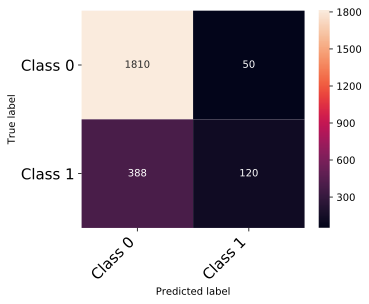

In [35]:
cm_knn = print_confusion_matrix(confusion_matrix(y_train, knn_grid.predict(X_train)), ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15)

### Logistic Regression GridSearchCV

In [33]:
# Run CV with 5 folds (logit)

penalty = ['l1', 'l2'] # look into doing elastic net here to see what combo of l1 and l2 is best
C = np.logspace(-3, 1, 100)
param_grid = dict(C=C, penalty=penalty)

logistic = linear_model.LogisticRegression(solver='liblinear', max_iter=10000)
logistic_grid = GridSearchCV(logistic, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
logistic_grid.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0331s.) Setting batch_size=12.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 308 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 548 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 836 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    7.9s finished
/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=10000, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([1.00...
       2.47707636e+00, 2.71858824e+00, 2.98364724e+00, 3.27454916e+00,
       3.59381366e+00, 3.94420606e+00, 4.32876128e+00, 4.75081016e+00,
       5.21400829e+00, 5.72236766e+00, 6.28029144e+00, 6.89261210e+00,
       7.56463328e+00, 8.30217568e+00, 9.11162756e+00, 1.00000000e+01]),
       

In [34]:
# best model for logistic regression (metric = C)

logistic_grid.best_estimator_

LogisticRegression(C=0.26560877829466867, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='warn', n_jobs=None,
                   penalty='l1', random_state=None, solver='liblinear',
                   tol=0.0001, verbose=0, warm_start=False)

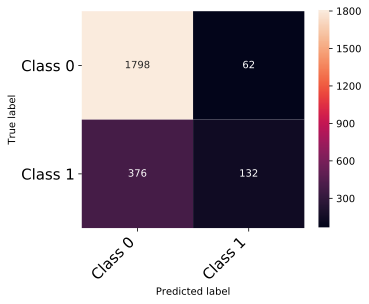

In [36]:
cm_log = print_confusion_matrix(confusion_matrix(y_train, logistic_grid.predict(X_train)), ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15)

Logistic regression coefficients allow us to understand the importance of the features in our model, and the correlation they have with the target variable (direct or indirect). Here we calculate the feature importances using the parameters from the best estimate of the logistic regression model. 

In [37]:
# run logistic regression again with the model parameters from the best estimate
# in preparation to get feature importances

logistic2 = linear_model.LogisticRegression(C=0.02848035868435802, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) # ADD PARAMETERS FROM BEST ESTIMATE
logistic2.fit(X_train, y_train)

/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=0.02848035868435802, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='warn', n_jobs=None,
                   penalty='l1', random_state=None, solver='liblinear',
                   tol=0.0001, verbose=0, warm_start=False)

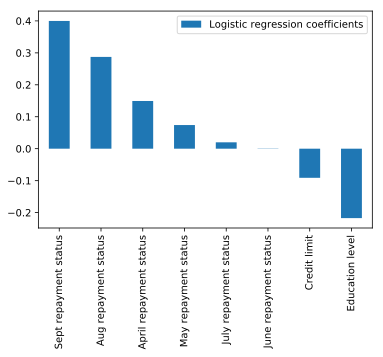

In [39]:
# get logistic regression coefficients to understand feature importances
a = logistic2.coef_

# make dataframe with features and corresponding coefficients
df_a = pd.DataFrame(a, columns = ['Age', 'Sept bill', 'Aug bill', 'July bill', 'June bill','May bill', 'April bill', 
                                  'Sept payment', 'Aug payment', 'July payment', 'June payment', 'May payment', 'April payment',
                                  'Credit limit', 'Education level',
                                  'Sept repayment status', 'Aug repayment status', 'July repayment status', 'June repayment status', 'May repayment status', 'April repayment status',
                                  'Gender', 'Marital status, others', 'Marital status, single'])
df_a = df_a.transpose()
df_a.rename({df_a.columns.values[0]:'Logistic regression coefficients'}, axis='columns', inplace=True)
df_a.sort_values(by='Logistic regression coefficients', ascending=False, inplace=True)
df_a = df_a[(df_a.T != 0).any()]
df_a.plot.bar()

plt.savefig('~/Metis/Projects/Project 3/credit_payment_default/logit_feature_importances.png', dpi=300, bbox_inches = 'tight')
df_a.to_excel("logit_feature_importances.xlsx", sheet_name='logit')


From these feature importances, we see that the repayment status each month has a large impact on the likelihood of an individual defaulting on their credit card payment. The later they make their monthly payment, the more likely they are to default. We also see that individuals with a higher credit limit and a higher education level are less likely to default on their payments. 


A note on Random Forest vs. logistic regression feature importances:
Ultimately, the best model here turned out to be the Random Forest model. However, the feature importances from logistic regression (which didn't have much lower of an ROC-AUC score compared to the Random Forest model) made more intuitive sense. 

### SVM GridSearchCV

In [40]:
# Run CV with 5 folds (SVM)

C = np.logspace(-3, 1, 25)
gammas = np.logspace(-3, 0, 25)
param_grid = dict(C=C, gamma=gammas)

svm1 = svm.SVC(kernel='rbf', probability=True)
svm_grid = GridSearchCV(svm1, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
svm_grid.fit(X_train, y_train)

Fitting 5 folds for each of 625 candidates, totalling 3125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.46779927e-03,...
                         'gamma': array([0.001     , 0.00133352, 0.00177828, 0.00237137, 0.00316228,
       0.00421697, 0.00562341, 0.00749894, 0.01      , 0.01333521,
       0.01778279, 0.02371374, 0.03162278, 0.04216965, 0.05623413,
       0.07498942, 0.1       , 0.13335214, 0.17782794, 0.23713737,
       0.31622777, 0.4216965 , 0.56234133, 0.74989421, 1.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc',

In [41]:
svm_grid.best_estimator_

SVC(C=4.6415888336127775, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.042169650342858224,
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

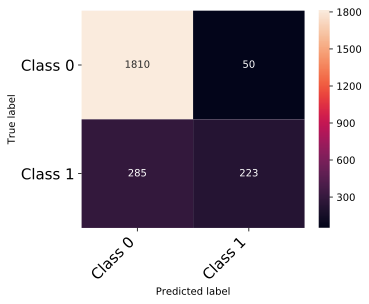

In [42]:
cm_svm = print_confusion_matrix(confusion_matrix(y_train, svm_grid.predict(X_train)), ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15)

### Naive Bayes Model

In [43]:
# Fit a Naive Bayes Model

gnb = GaussianNB()
gnb_best = gnb.fit(X_train, y_train)

/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


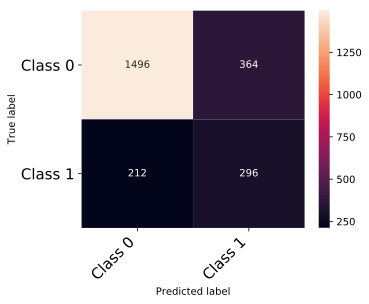

In [44]:
cm_gnb = print_confusion_matrix(confusion_matrix(y_train, gnb_best.predict(X_train)), ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15)

### Random Forest GridSearchCV

In [45]:
# Run CV with 5 folds (Random Forest)

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 100, None],
    'max_features': ['sqrt'], # what is this?
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': [2, 3, 5, 10],
    'n_estimators': [100, 200, 400, 1000]
}

rf = RandomForestClassifier()
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [46]:
rf_grid.best_params_


{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 3,
 'n_estimators': 100}

In [47]:
rf_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [48]:
# rf_model with best params

rf_model = RandomForestClassifier(bootstrap = True, max_depth = None, max_features = 'sqrt', min_samples_leaf = 10, 
                                  min_samples_split = 10, n_estimators = 200)


In [49]:
# final model to pickle to use in Flask app

rf_model = rf_model.fit(X_train, np.array(y_train))


/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [69]:
# pickling final model for Flask app

filename = 'credit_card_default_model.sav'
with open (filename, 'wb') as file:
    pickle.dump(rf_model, file)

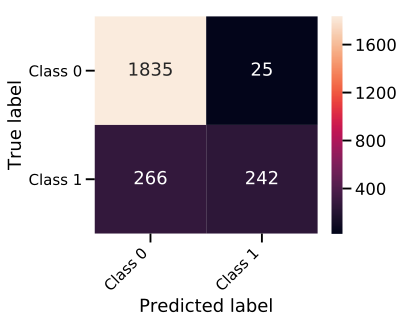

In [70]:
cm_rf = print_confusion_matrix(confusion_matrix(y_train, rf_grid.predict(X_train)), ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15)

Random Forest feature importances allow us to understand the importance of the features in our model, but not the correlation they have with the target variable, as in the case of logistic regression coefficients. Here we calculate the feature importances based on the Random Forest model using the parameters from the model's best estimate. 

In [71]:
# Random Forest Feature Importances

rf2 = RandomForestRegressor(n_estimators=200, max_depth = None)
rf2.fit(X_train, y_train)
rf2.feature_importances_

/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


array([0.07363971, 0.06558964, 0.04665023, 0.04607886, 0.03903847,
       0.05027887, 0.05399692, 0.04909389, 0.05838946, 0.05194968,
       0.04886885, 0.05150256, 0.0646327 , 0.06113402, 0.01727421,
       0.07508715, 0.0865933 , 0.0087204 , 0.00780919, 0.01071033,
       0.01170077, 0.00987895, 0.0021355 , 0.00924631])

In [72]:
# zip each feature importance weight with my columns

rf_feature_importances = pd.DataFrame(zip(list(rf2.feature_importances_), X_train.columns), columns=['feature_importances', 'feature_names'])
rf_feature_importances.sort_values(by='feature_importances')

,feature_importances,feature_names
22,0.002136,others
18,0.007809,pay_4
17,0.008720,pay_3
23,0.009246,single
21,0.009879,sex
19,0.010710,pay_5
20,0.011701,pay_6
14,0.017274,education_level
4,0.039038,bill_amt_4
3,0.046079,bill_amt_3


In [73]:
# Graph feature importances using train dataset

imp = importances(rf2, X_train, y_train)

# rename index labels to improve readability of feature importances visualization

imp['Feature2'] = imp.index

imp['Feature2'] = imp['Feature2'].map({'pay_0': 'Sept repayment status', 'limit_balance': 'Credit limit',
                                     'pay_2': 'Aug repayment status', 'pay_amt_2': 'Aug payment', 'bill_amt_3': 'July bill', 
                                     'pay_amt_6': 'April payment', 'age': 'Age', 'bill_amt_6': 'April bill', 'bill_amt_5': 'May bill',
                                     'bill_amt_1': 'Sept bill', 'pay_amt_3': 'July payment', 'pay_amt_5': 'Aug payment', 
                                     'bill_amt_2': 'Aug bill', 'pay_amt_1': 'Sept payment', 'bill_amt_4': 'July bill', 'pay_amt_4': 'July payment', 
                                     'pay_3': 'July repayment status', 'pay_4': 'June repayment status', 'pay_6': 'April repayment status', 
                                     'education_level': 'Education Level', 'pay_5': 'May repayment status', 'single': 'Marital status, single',
                                     'sex': 'Gender', 'others': 'Marital status: others'})

# imp.drop(columns=['Feature'], axis=1, inplace=True)

imp.set_index('Feature2', inplace = True)

imp

# imp.to_excel

,Importance
Feature2,
Sept repayment status,0.278707
Credit limit,0.237999
Aug repayment status,0.215118
Aug payment,0.174672
July bill,0.158196
Age,0.151038
April payment,0.146773
April bill,0.118830
May bill,0.105575


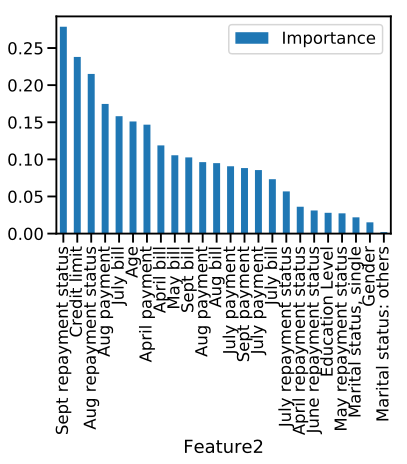

In [74]:
imp.plot.bar()
plt.savefig('~/Metis/Projects/Project 3/credit_payment_default/RF_feature_importances_2.png', dpi=300, bbox_inches = 'tight')

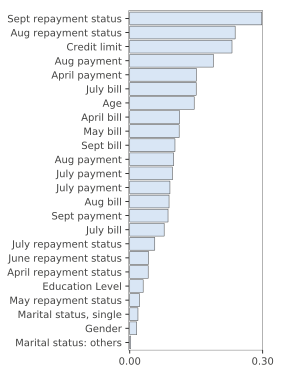

In [59]:
# more aesthetic plot of feature importances

viz = plot_importances(imp)
plt.savefig('~/Metis/Projects/Project 3/credit_payment_default/RF_feature_importances.png', dpi=300, bbox_inches = 'tight')
viz.view()

In [78]:
# predicted y values based on final model

y_pred = rf_model.predict_proba(X_test)[:,1]

# Scoring the models

### ROC_AUC

In [79]:
print('Best ROC_AUC for knn: %0.4f' % knn_grid.best_score_)
print('Best ROC_AUC for logit: %0.4f' % logistic_grid.best_score_)
print('Best ROC_AUC for svm: %0.4f' % svm_grid.best_score_)
print('Best ROC_AUC for rf: %0.4f' % rf_grid.best_score_)

Best ROC_AUC for knn: 0.7213
Best ROC_AUC for logit: 0.7212
Best ROC_AUC for svm: 0.7279
Best ROC_AUC for rf: 0.7434


### Best parameters

In [80]:
print('Best Params for knn: ', knn_grid.best_params_)
print('Best Patams for logit: ', logistic_grid.best_params_)
print('Best Params for svm: ', svm_grid.best_params_)
print('Best Params for rf: ', rf_grid.best_params_)

Best Params for knn:  {'n_neighbors': 51}
Best Patams for logit:  {'C': 0.26560877829466867, 'penalty': 'l1'}
Best Params for svm:  {'C': 4.6415888336127775, 'gamma': 0.042169650342858224}
Best Params for rf:  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 100}


### F1 Scores

In [81]:
# Generate data frame of model test statistics

y_probs = model.predict_proba(X_test)[:,1]
thresholds = []
precisions = []
recall = []
tn = []
fp = []
fn = []
tp = []

for t in range(0,105,10):
    y_pred = pd.Series(y_probs).apply(lambda x: 0 if x<t/100 else 1)
    thresholds.append(t/100)
    precisions.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    tn.append(confusion_matrix(y_test, y_pred)[0][0])
    fp.append(confusion_matrix(y_test, y_pred)[0][1])
    fn.append(confusion_matrix(y_test, y_pred)[1][0])
    tp.append(confusion_matrix(y_test, y_pred)[1][1])


test_statistics = pd.DataFrame(
    {'Threshold': thresholds,
     'Precision': precisions,
     'Recall' : recall,
     'True_Negative': tn,
     'False_Positive': fp,
     'False_Negative': fn,
     'True_Positive': tp,
    })

test_statistics

/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Threshold,Precision,Recall,True_Negative,False_Positive,False_Negative,True_Positive
0,0.0,0.214165,1.000000,0,466,0,127
1,0.1,0.227017,0.952756,54,412,6,121
2,0.2,0.371901,0.708661,314,152,37,90
3,0.3,0.615385,0.566929,421,45,55,72
4,0.4,0.677419,0.496063,436,30,64,63
5,0.5,0.698630,0.401575,444,22,76,51
6,0.6,0.771429,0.212598,458,8,100,27
7,0.7,0.785714,0.086614,463,3,116,11
8,0.8,1.000000,0.007874,466,0,126,1
9,0.9,0.000000,0.000000,466,0,127,0


In [82]:
# score on F1
# tuning thresholds on F1 score

y_true = y_test

# Using a threshold of 0.3 (based on above dataframe of test statistics)
# which means that anything above a probability of 0.3 will be classified as positive
y_predict = (model.predict_proba(X_test)[:, 1] > 0.2)
f1_score(y_true, y_predict)


## Note: I would want to improve the model later, but this score is decent

0.4878048780487804

In [65]:
# Use test set to measure model performance

y_pred = model.predict_proba(X_test)

cutoff = 0.1

y_class = []
for i in y_pred[:,1]:
    if i >= cutoff:
        y_class.append(1)
    else:
        y_class.append(0)
    
conf_mat = metrics.confusion_matrix(y_test, y_class)
print(conf_mat)
my_default_rate = conf_mat[1,0]/(conf_mat[0,0] + conf_mat[1,0])
total_default_rate = np.sum(conf_mat, axis=1)[1]/(np.sum(conf_mat, axis=1)[0] + np.sum(conf_mat, axis=1)[1])
print('Test Set Default Rate of Model Loans %.2f' % (my_default_rate*100), '%')
print('Test Set Default Rate of All Loans %.2f' % (total_default_rate*100), '%')

[[ 53 413]
 [  5 122]]
Test Set Default Rate of Model Loans 8.62 %
Test Set Default Rate of All Loans 21.42 %


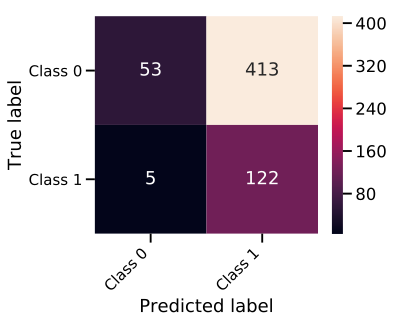

In [83]:
# confusion matrix on final RF model
# model = pickle.load(open('flask_app/credit_card_default_model.sav', 'rb'))
cm = print_confusion_matrix(confusion_matrix(y_test, y_class), ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15)

/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClas

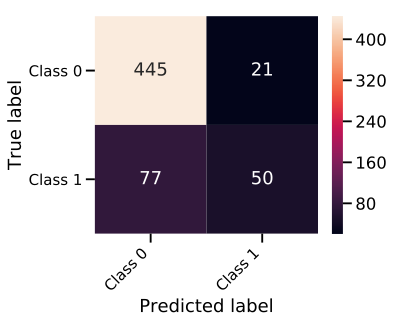

In [84]:
# confusion matrix on final RF model
# model = pickle.load(open('flask_app/credit_card_default_model.sav', 'rb'))
cm = print_confusion_matrix(confusion_matrix(y_test, rf_model.predict(X_test)), ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15)
cm.savefig('~/Metis/Projects/Project 3/credit_payment_default/rf_final_model_cm.png', dpi=300, bbox_inches = 'tight')


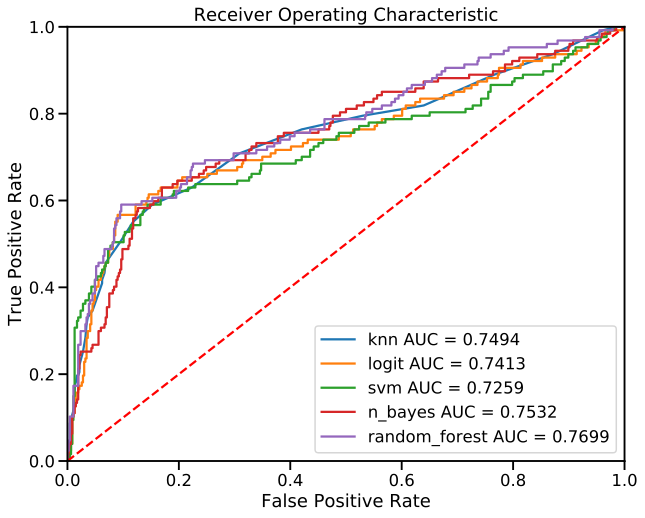

In [85]:
# ROC for all the models

sns.set_context("talk")


model_list = [knn_grid.best_estimator_, 
              logistic_grid.best_estimator_, 
              svm_grid.best_estimator_, 
              gnb_best, 
              rf_grid.best_estimator_]
model_name = ['knn', 'logit', 'svm', 'n_bayes', 'random_forest']

# Plot ROC curve for all my models
fig, ax = plt.subplots(figsize=(10,8))
for i, model in enumerate(model_list):
    y_pred = list(model.predict_proba(X_test)[:,1])
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = (model_name[i] + ' AUC = %0.4f' % roc_auc))


plt.legend(loc = 'lower right')
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('~/Metis/Projects/Project 3/credit_payment_default/ROC-AUC_curves.png', dpi=300, bbox_inches = 'tight')
plt.show()

Other confusion matrix formatting options:

In [ ]:
# Make Confusion Matrix with percentages
cm_percentages = confusion_matrix(y_test,model.predict_proba(X_test)[:,1]>=.2)
mat_confusion_test= cm_test.astype('float') / cm_test.sum()
mat_confusion_test = mat_confusion_test.round(2)

plt.figure(dpi=300);
plt.figure(figsize=(12, 12));

sns.set(font_scale=2)
sns.heatmap(mat_confusion_test, cmap=plt.cm.Purples, annot=True, square=True,
            fmt='.0%', cbar = False, annot_kws={"size": 100},
       xticklabels=['Paid off', 'Defaulted'],
       yticklabels=['Paid off', 'Defaulted']);
plt.xlabel('Prediction',fontname = '.SF Compact Display',fontsize = 30,fontweight = 'bold')
plt.ylabel('Actual',fontname = '.SF Compact Display',fontsize = 30,rotation = 0)
plt.yticks(rotation = 0)
plt.title('Predictions vs. Actual Relative to Total',fontname = '.SF Compact Display',fontsize = 36,pad = 20);
plt.savefig('~/Metis/Projects/Project 3/credit_payment_default/cm_rf_F1', dpi=300, bbox_inches = "tight")

In [ ]:
cm_2 = confusion_matrix(y_test,model.predict_proba(X_test)[:,1]>=0.2)
plt.figure(figsize=(25,7))
plt.subplot(131)
ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False,
               annot_kws={"size": 20}, fmt='g')
cmlabels = ['True Negatives', 'False Positives',
             'False Negatives', 'True Positives']
for i,t in enumerate(ax.texts):
   t.set_text(t.get_text() + "\n" + cmlabels[i])
plt.title('Confusion Matrix - Random Forest', size=25)
plt.xlabel('Predicted Default Outcome', size=20)
plt.ylabel('Actual Default Outcome', size=20)
labels = ['Paid off', 'Defaulted']
ax.set_xticklabels(labels, size = 20)
ax.set_yticklabels(labels, size = 20)
plt.tight_layout()
plt.savefig('Confusion_matrix_Logistic.png')
plt.savefig('Confusion_matrix_Logistic.svg')
plt.savefig('~/Metis/Projects/Project 3/credit_payment_default/cm_rf_F1', dpi=300, bbox_inches = "tight")
plt.show()